In [13]:
pip install matplotlib networkx ffmpeg pillow

Note: you may need to restart the kernel to use updated packages.


## 📥 Step 1: Load Your Dataset

In [14]:
from scipy.io import mmread
import networkx as nx

mtx_path = "econ-wm1.mtx"
matrix = mmread(mtx_path)
coo = matrix.tocoo()

G = nx.Graph()
for i, j, w in zip(coo.row, coo.col, coo.data):
    if i != j:
        G.add_edge(int(i), int(j), weight=float(w))

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

if not nx.is_connected(G):
    G = G.subgraph(max(nx.connected_components(G), key=len)).copy()
    print(f"Using largest connected component: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")


Graph has 258 nodes and 2389 edges.


## 🌿 Kruskal’s Algorithm

In [15]:
import time
start = time.time()
MST_kruskal = nx.minimum_spanning_tree(G, algorithm='kruskal')
end = time.time()
kruskal_cost = MST_kruskal.size(weight='weight')
kruskal_time = end - start
print(f"Kruskal MST cost: {kruskal_cost:.2f}")
print(f"Execution time: {kruskal_time:.4f} seconds")

Kruskal MST cost: -196.01
Execution time: 0.0072 seconds


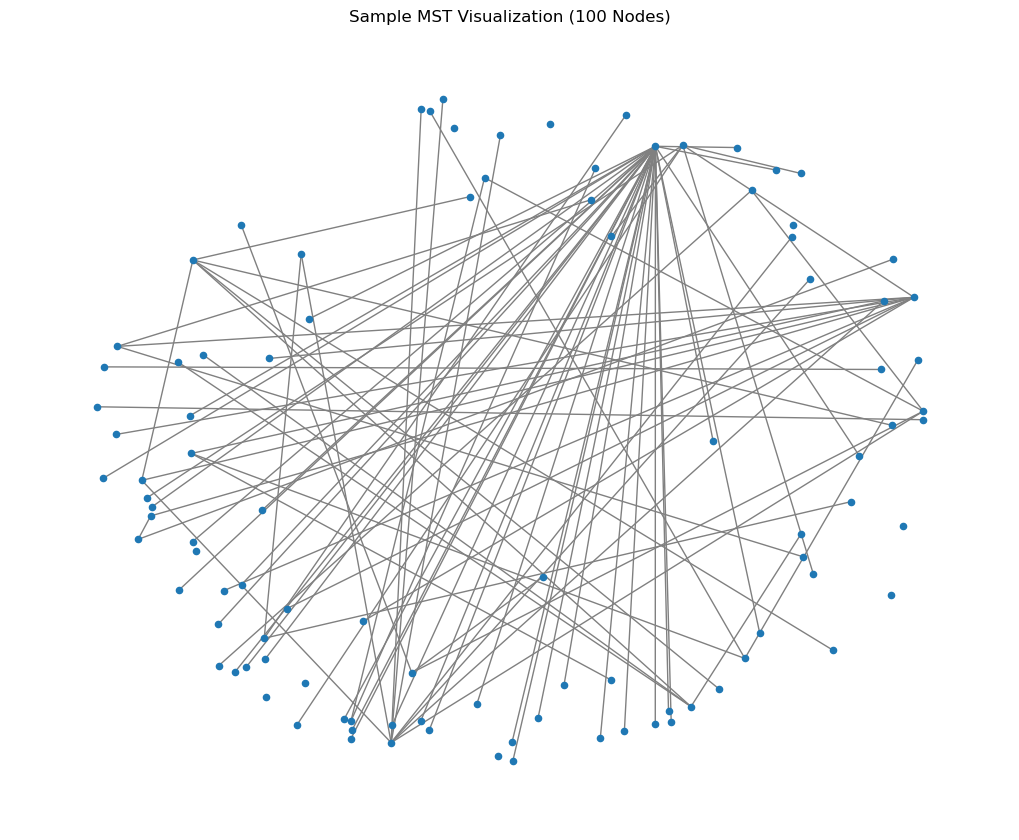

In [16]:
import matplotlib.pyplot as plt
import networkx as nx

sub_nodes = list(MST_kruskal.nodes)[:100]
subgraph = MST_kruskal.subgraph(sub_nodes)

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subgraph, seed=42)
nx.draw(subgraph, pos, node_size=20, edge_color='gray', with_labels=False)
plt.title('Sample MST Visualization (100 Nodes)')
plt.show()

In [17]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx

# Select subgraph to animate (e.g., 100 nodes for clarity)
sub_nodes = list(MST_kruskal.nodes)[:100]
subgraph = MST_kruskal.subgraph(sub_nodes)
edges = list(subgraph.edges(data=True))

# Prepare positions (fixed for animation)
pos = nx.spring_layout(subgraph, seed=42)

# Set up the figure
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title("MST Construction Animation (100 Nodes)")

# Initialize graph for animation
G_anim = nx.Graph()
total_cost = [0]  # cumulative cost

# Create line object for displaying total MST cost
text_obj = ax.text(0.05, 0.95, "", transform=ax.transAxes, fontsize=12, verticalalignment='top')

def update(num):
    ax.clear()
    ax.set_title(f"Step {num+1} / {len(edges)}", fontsize=14)
    G_anim.add_edge(edges[num][0], edges[num][1])
    weight = edges[num][2].get('weight', 1)
    total_cost[0] += weight

    nx.draw(G_anim, pos, ax=ax, node_size=30, edge_color='black', with_labels=False)
    text_obj = ax.text(0.05, 0.95, f"Total MST Cost: {total_cost[0]:.2f}", transform=ax.transAxes,
                       fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6))

    return ax

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(edges), interval=300, repeat=False)

# Save as MP4 or GIF
ani.save("mst_animation_wm1_kruskal.gif", writer="pillow", dpi=200)
# Or: ani.save("mst_animation.gif", writer="pillow")

plt.close()
print("✅ Animation saved successfully as 'mst_animation_wm1_kruskal.mp4'")

✅ Animation saved successfully as 'mst_animation_wm1_kruskal.mp4'


## 🌲 Prim’s Algorithm

In [18]:
start = time.time()
MST_prim = nx.minimum_spanning_tree(G, algorithm='prim')
end = time.time()
prim_cost = MST_prim.size(weight='weight')
prim_time = end - start
print(f"Prim MST cost: {prim_cost:.2f}")
print(f"Execution time: {prim_time:.4f} seconds")

Prim MST cost: -196.01
Execution time: 0.0037 seconds


In [19]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx

# Select subgraph to animate (e.g., 100 nodes for clarity)
sub_nodes = list(MST_prim.nodes)[:100]
subgraph = MST_prim.subgraph(sub_nodes)
edges = list(subgraph.edges(data=True))

# Prepare positions (fixed for animation)
pos = nx.spring_layout(subgraph, seed=42)

# Set up the figure
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title("MST Construction Animation (100 Nodes)")

# Initialize graph for animation
G_anim = nx.Graph()
total_cost = [0]  # cumulative cost

# Create line object for displaying total MST cost
text_obj = ax.text(0.05, 0.95, "", transform=ax.transAxes, fontsize=12, verticalalignment='top')

def update(num):
    ax.clear()
    ax.set_title(f"Step {num+1} / {len(edges)}", fontsize=14)
    G_anim.add_edge(edges[num][0], edges[num][1])
    weight = edges[num][2].get('weight', 1)
    total_cost[0] += weight

    nx.draw(G_anim, pos, ax=ax, node_size=30, edge_color='black', with_labels=False)
    text_obj = ax.text(0.05, 0.95, f"Total MST Cost: {total_cost[0]:.2f}", transform=ax.transAxes,
                       fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6))

    return ax

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(edges), interval=300, repeat=False)

# Save as MP4 or GIF
ani.save("mst_animation_wm1_prim.gif", writer="pillow", dpi=200)
# Or: ani.save("mst_animation.gif", writer="pillow")

plt.close()
print("✅ Animation saved successfully as 'mst_animation_wm1_prim.mp4'")

✅ Animation saved successfully as 'mst_animation_wm1_prim.mp4'


## 🧩 Borůvka’s Algorithm

In [20]:
from networkx.algorithms.tree import branchings

def boruvka_mst(graph):
    from networkx.utils import UnionFind
    forest = list(graph.edges(data=True))
    uf = UnionFind()
    mst_edges = []
    start = time.time()
    nodes = list(graph.nodes())
    while len(set(uf[x] for x in nodes)) > 1:
        cheapest = {}
        for u, v, d in forest:
            ru, rv = uf[u], uf[v]
            if ru != rv:
                if ru not in cheapest or cheapest[ru][2]['weight'] > d['weight']:
                    cheapest[ru] = (u, v, d)
                if rv not in cheapest or cheapest[rv][2]['weight'] > d['weight']:
                    cheapest[rv] = (u, v, d)
        for edge in cheapest.values():
            u, v, d = edge
            if uf[u] != uf[v]:
                uf.union(u, v)
                mst_edges.append((u, v, d))
    MST = nx.Graph()
    MST.add_edges_from(mst_edges)
    end = time.time()
    return MST, MST.size(weight='weight'), end - start

MST_boruvka, boruvka_cost, boruvka_time = boruvka_mst(G)
print(f"Borůvka MST cost: {boruvka_cost:.2f}")
print(f"Execution time: {boruvka_time:.4f} seconds")

Borůvka MST cost: -196.01
Execution time: 0.0043 seconds


In [21]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx

# Select subgraph to animate (e.g., 100 nodes for clarity)
sub_nodes = list(MST_boruvka.nodes)[:100]
subgraph = MST_boruvka.subgraph(sub_nodes)
edges = list(subgraph.edges(data=True))

# Prepare positions (fixed for animation)
pos = nx.spring_layout(subgraph, seed=42)

# Set up the figure
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title("MST Construction Animation (100 Nodes)")

# Initialize graph for animation
G_anim = nx.Graph()
total_cost = [0]  # cumulative cost

# Create line object for displaying total MST cost
text_obj = ax.text(0.05, 0.95, "", transform=ax.transAxes, fontsize=12, verticalalignment='top')

def update(num):
    ax.clear()
    ax.set_title(f"Step {num+1} / {len(edges)}", fontsize=14)
    G_anim.add_edge(edges[num][0], edges[num][1])
    weight = edges[num][2].get('weight', 1)
    total_cost[0] += weight

    nx.draw(G_anim, pos, ax=ax, node_size=30, edge_color='black', with_labels=False)
    text_obj = ax.text(0.05, 0.95, f"Total MST Cost: {total_cost[0]:.2f}", transform=ax.transAxes,
                       fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6))

    return ax

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(edges), interval=300, repeat=False)

# Save as MP4 or GIF
ani.save("mst_animation_wm1_boruvka.gif", writer="pillow", dpi=200)
# Or: ani.save("mst_animation.gif", writer="pillow")

plt.close()
print("✅ Animation saved successfully as 'mst_animation_wm1_boruvka.mp4'")

✅ Animation saved successfully as 'mst_animation_wm1_boruvka.mp4'


## 🔁 Reverse-delete Algorithm (sample only)

In [22]:
def reverse_delete_mst(graph):
    sorted_edges = sorted(graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
    MST = graph.copy()
    start = time.time()
    for u, v, data in sorted_edges:
        weight = data['weight']
        MST.remove_edge(u, v)
        if not nx.is_connected(MST):
            MST.add_edge(u, v, weight=weight)
    end = time.time()
    return MST, MST.size(weight='weight'), end - start

G_sample = G.subgraph(list(G.nodes)[:300]).copy()
MST_rd, rd_cost, rd_time = reverse_delete_mst(G_sample)
print(f"Reverse-delete MST cost: {rd_cost:.2f}")
print(f"Execution time: {rd_time:.4f} seconds")

Reverse-delete MST cost: -196.01
Execution time: 0.3545 seconds


In [23]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx

# Select subgraph to animate (e.g., 100 nodes for clarity)
sub_nodes = list(MST_kruskal.nodes)[:100]
subgraph = MST_kruskal.subgraph(sub_nodes)
edges = list(subgraph.edges(data=True))

# Prepare positions (fixed for animation)
pos = nx.spring_layout(subgraph, seed=42)

# Set up the figure
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title("MST Construction Animation (100 Nodes)")

# Initialize graph for animation
G_anim = nx.Graph()
total_cost = [0]  # cumulative cost

# Create line object for displaying total MST cost
text_obj = ax.text(0.05, 0.95, "", transform=ax.transAxes, fontsize=12, verticalalignment='top')

def update(num):
    ax.clear()
    ax.set_title(f"Step {num+1} / {len(edges)}", fontsize=14)
    G_anim.add_edge(edges[num][0], edges[num][1])
    weight = edges[num][2].get('weight', 1)
    total_cost[0] += weight

    nx.draw(G_anim, pos, ax=ax, node_size=30, edge_color='black', with_labels=False)
    text_obj = ax.text(0.05, 0.95, f"Total MST Cost: {total_cost[0]:.2f}", transform=ax.transAxes,
                       fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6))

    return ax

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(edges), interval=300, repeat=False)

# Save as MP4 or GIF
ani.save("mst_animation_wm1_RD.gif", writer="pillow", dpi=200)
# Or: ani.save("mst_animation.gif", writer="pillow")

plt.close()
print("✅ Animation saved successfully as 'mst_animation_wm1_RD.mp4'")

✅ Animation saved successfully as 'mst_animation_wm1_RD.mp4'


## 🎲 Karger’s Min-Cut (Optional)

In [24]:
import time
import random
import networkx as nx

def karger_min_cut(graph, iterations=10):
    min_cut = float('inf')
    
    for _ in range(iterations):
        G_temp = graph.copy()  # fast shallow copy
        while G_temp.number_of_nodes() > 2:
            edges = list(G_temp.edges)
            if not edges:  # safety check
                break
            u, v = random.choice(edges)
            nx.contracted_nodes(G_temp, u, v, self_loops=False, copy=False)
        cut_edges = G_temp.number_of_edges()
        min_cut = min(min_cut, cut_edges)

    return min_cut

# Safe subgraph slicing (in case G has <500 nodes)
sub_nodes = list(G.nodes)[:min(500, G.number_of_nodes())]
G_karger = G.subgraph(sub_nodes).copy()

# ⏱ Timing
start = time.time()
min_cut_value = karger_min_cut(G_karger, iterations=20)
end = time.time()

# ✅ Output
print(f"Karger min cut (≤500 nodes): {min_cut_value}")
print(f"Execution time: {end - start:.2f} seconds")

Karger min cut (≤500 nodes): 1
Execution time: 0.72 seconds


## 📊 Final Comparison Charts

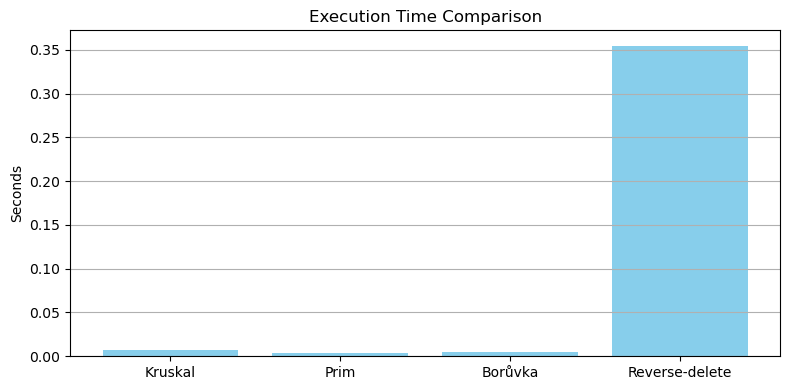

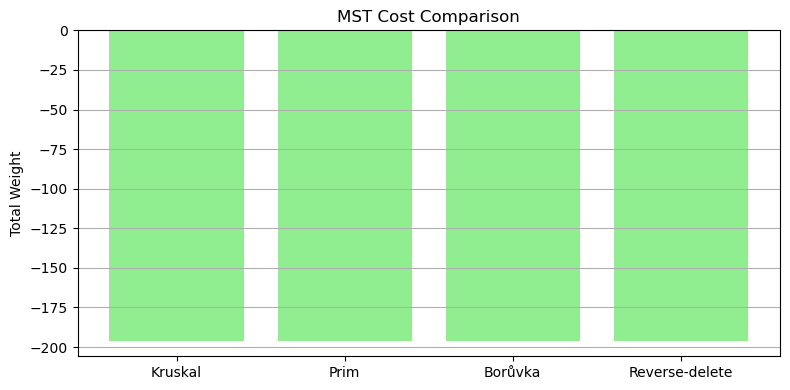

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    "Algorithm": ["Kruskal", "Prim", "Borůvka", "Reverse-delete"],
    "Execution Time (s)": [kruskal_time, prim_time, boruvka_time, rd_time],
    "MST Cost": [kruskal_cost, prim_cost, boruvka_cost, rd_cost]
}

df = pd.DataFrame(data)

# Plot execution time
plt.figure(figsize=(8, 4))
plt.bar(df["Algorithm"], df["Execution Time (s)"], color="skyblue")
plt.title("Execution Time Comparison")
plt.ylabel("Seconds")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Plot MST Cost
plt.figure(figsize=(8, 4))
plt.bar(df["Algorithm"], df["MST Cost"], color="lightgreen")
plt.title("MST Cost Comparison")
plt.ylabel("Total Weight")
plt.grid(axis='y')
plt.tight_layout()
plt.show()